In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ergochemics.mapping import get_reaction_center
from rdkit import Chem
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
import numpy as np
import polars as pl
from src.post_processing import PathWrangler
from pathlib import Path
from hydra import compose, initialize
from pathlib import Path

with initialize(version_base=None, config_path="../conf/filepaths"):
    cfg = compose(config_name="filepaths")

In [25]:
paths = pl.read_parquet(Path(cfg.processed_data) / "test/paths.parquet")
path_stats = pl.read_parquet(Path(cfg.processed_data) / "test/path_stats.parquet")
prxns = pl.read_parquet(Path(cfg.processed_data) / "test/predicted_reactions.parquet")
print(len(paths), len(path_stats), len(prxns))

674 674 672


In [22]:
path_stats.head()

id,starters,targets,dg_opt,dg_err,starter_ids,target_ids,mdf,mean_max_rxn_sim,mean_mean_rxn_sim,min_max_rxn_sim,min_mean_rxn_sim,feasibility_frac
str,list[str],list[str],list[f32],list[f32],list[str],list[str],f32,f32,f32,f32,f32,f32
"""131d4e8cc388978209d8859761419f…","[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,null,null,null,null
"""131d4e8cc388978209d8859761419f…","[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,null,null,null,null
"""131d4e8cc388978209d8859761419f…","[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,null,null,null,null
"""f0c511e4e6eddb55648c8ffc502f7b…","[""eb0826042299f197144703ad548040755939ca3a"", ""17d2ab53c78bed104290bde729ad657b5da216bb"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""eb0826042299f197144703ad548040755939ca3a"", ""17d2ab53c78bed104290bde729ad657b5da216bb"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,null,null,null,null
"""f0c511e4e6eddb55648c8ffc502f7b…","[""eb0826042299f197144703ad548040755939ca3a"", ""17d2ab53c78bed104290bde729ad657b5da216bb"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""eb0826042299f197144703ad548040755939ca3a"", ""17d2ab53c78bed104290bde729ad657b5da216bb"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,null,null,null,null


In [26]:
print(len(paths.unique()))
print(len(path_stats.unique()))
print(len(prxns.unique()))

674
149
155


In [3]:
enzymes = pl.read_parquet(Path(cfg.known_enzymes))

print(enzymes.schema)
print(len(enzymes.filter(pl.col("existence") == 'Predicted')))
print(len(enzymes.filter(pl.col("existence") == 'Uncertain')))
print(len(enzymes.filter(pl.col("existence") == 'Inferred from homology')))

Schema({'id': String, 'sequence': String, 'existence': Enum(categories=['Predicted', 'Uncertain', 'Inferred from homology', 'Evidence at transcript level', 'Evidence at protein level']), 'reviewed': Enum(categories=['reviewed', 'unreviewed']), 'ec': String, 'organism': String, 'name': String})
115
66
153695


In [4]:
study = "test" # test

In [5]:
pw = PathWrangler(study=Path(cfg.processed_data) / study, known=Path(cfg.known))

In [6]:
pw.starters, pw.targets

(('c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561',
  '107689e3f574227f080ebd294ba5a5812ee482b8',
  '795ce8b8f679817da1f0333c1a7ab70424422dd2',
  'cb848d6e084f84f1b1e822d792627b1a4a468fb1',
  'cdc4428117795cc5bfaa84065e77dab7e6189ec5',
  '1aa818910461f5961959eb05dd06b8f7a4fbbb9f',
  'da7b7aacec3c6f733a01920b971ac0deda5d3303',
  '692a548c92224b659ae0c86b41bc9c528cb04b13',
  '6a2307f86745c292bc504cdf358769d6ed6f1136',
  '87d60fa4fabb6d8bbe8d8eab7454bcbb52f40391',
  '17d2ab53c78bed104290bde729ad657b5da216bb',
  'feb250ca15352be2458187d980361aa22951cb6e',
  '08a914cde05039694ef0194d9ee79ff9a79dde33',
  'eb0826042299f197144703ad548040755939ca3a',
  'e6490b8cb18f68ed72b12d82460b1384c017d3c6',
  '39d4c5fe879532638d4eb8c238678a42b9484858',
  'a96e088ce21c364e21e6ad6ef98ad04c78a93725',
  '5cefc5e9c89bd03ca8bbe754734d0936b0fc8dbd',
  '27e471428018c3779a1b13dec34fcbc3d80f6c28',
  'e6391017f3400cdaaf0f93cd626f18f54502fae9',
  'ce24523c462f2d2885687bed7e180898bdffb729'),
 ('b4419ef13b0e2ce0034b0dfb2bda3a

In [7]:
batch = pw.get_paths(
    starters=pw.starters,
    targets=pw.targets,
    sort_by="min_max_rxn_sim",
    filter_by_enzymes={'existence': ["Evidence at protein level", "Evidence at transcript level"]},
)

paths = batch['paths']
prxns = batch['predicted_reactions']
krxns = batch['known_reactions']
enzs = batch['enzymes']

In [8]:
paths.head()

id,starters,targets,dg_opt,dg_err,starter_ids,target_ids,mdf,mean_max_rxn_sim,mean_mean_rxn_sim,min_max_rxn_sim,min_mean_rxn_sim,feasibility_frac,rxn_id,main_pdt_id,rxn_type,generation
str,list[str],list[str],list[f32],list[f32],list[str],list[str],f32,f32,f32,f32,f32,f32,str,str,enum,i32
"""6005e5dcd4495338ac45f9a577aa8b…","[""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,1.0,1.0,1.0,1.0,1.0,"""34499bb2958fb2016fb32cf0b11020…","""1f749b1bcce668758b15def5670a08…","""known""",0
"""131d4e8cc388978209d8859761419f…","[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,0.943651,0.821834,0.928571,0.750608,0.833333,"""2520a1aa291977ce9b7182e8026058…","""1f749b1bcce668758b15def5670a08…","""predicted""",0
"""131d4e8cc388978209d8859761419f…","[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,0.943651,0.821834,0.928571,0.750608,0.833333,"""2520a1aa291977ce9b7182e8026058…","""1f749b1bcce668758b15def5670a08…","""predicted""",0
"""131d4e8cc388978209d8859761419f…","[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,0.943651,0.821834,0.928571,0.750608,0.833333,"""2520a1aa291977ce9b7182e8026058…","""1f749b1bcce668758b15def5670a08…","""predicted""",0
"""131d4e8cc388978209d8859761419f…","[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,null,"[""17d2ab53c78bed104290bde729ad657b5da216bb"", ""eb0826042299f197144703ad548040755939ca3a"", ""c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561""]","[""1f749b1bcce668758b15def5670a0804bb5e80bf""]",null,0.943651,0.821834,0.928571,0.750608,0.833333,"""76bfe8656b87ff0474117b27ec3570…","""af5c3017bb9bdd62e0fef8720371fd…","""predicted""",1


In [19]:
print(len(paths))

3158


In [ ]:
pids = paths['id'].unique(maintain_order=True).to_list()
i = 0

149


Feasibility fraction: 1.000 | Min max reaction similarity: 1.000
Rxn id: 34499bb | Generation: 0 | Type: known


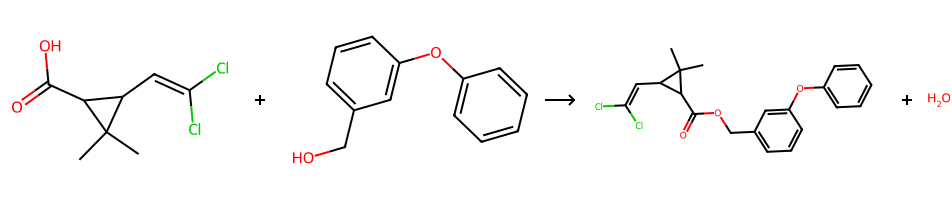

In [10]:
rxns_to_draw = paths.filter(pl.col('id') == pids[i]).unique().sort(by='generation').select(pl.col("rxn_id"), pl.col("generation"), pl.col("rxn_type"))
img_dir = Path(cfg.processed_data) / study / "svgs"

path_metrics = paths.filter(pl.col('id') == pids[i]).row(0, named=True)

print(f"Feasibility fraction: {path_metrics['feasibility_frac']:.3f} | Min max reaction similarity: {path_metrics['min_max_rxn_sim']:.3f}")
for rxn in rxns_to_draw.iter_rows(named=True):
    rid = rxn['rxn_id']
    gen = rxn['generation']
    rxn_type = rxn['rxn_type']
    print(f"Rxn id: {rid[:7]} | Generation: {gen} | Type: {rxn_type}")
    display(SVG(filename=img_dir / f"{rid}.svg"))

i += 1

In [11]:
path_metrics

{'id': '6005e5dcd4495338ac45f9a577aa8b43bbe586b2',
 'starters': ['eb0826042299f197144703ad548040755939ca3a',
  'c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561'],
 'targets': ['1f749b1bcce668758b15def5670a0804bb5e80bf'],
 'dg_opt': None,
 'dg_err': None,
 'starter_ids': ['eb0826042299f197144703ad548040755939ca3a',
  'c8d2bf09cec0f8fd65a9ea5f490f87e1a2413561'],
 'target_ids': ['1f749b1bcce668758b15def5670a0804bb5e80bf'],
 'mdf': None,
 'mean_max_rxn_sim': 1.0,
 'mean_mean_rxn_sim': 1.0,
 'min_max_rxn_sim': 1.0,
 'min_mean_rxn_sim': 1.0,
 'feasibility_frac': 1.0,
 'rxn_id': '34499bb2958fb2016fb32cf0b110202e2e12f12f',
 'main_pdt_id': '1f749b1bcce668758b15def5670a0804bb5e80bf',
 'rxn_type': 'known',
 'generation': 0}

In [12]:
kcs = pl.read_parquet(Path(cfg.known_compounds))

In [13]:
kcs.filter(pl.col("id") == "cdc4428117795cc5bfaa84065e77dab7e6189ec5")

id,smiles,name,chebi_id,n_atoms
str,str,str,str,i32
"""cdc4428117795cc5bfaa84065e77da…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""3-methylfumaryl-CoA""","""CHEBI:75636""",56


In [14]:
prxns.filter(
    pl.col("id").str.starts_with("9c2c777")
)

id,smarts,am_smarts,dxgb_label,rxn_sims,analogue_ids,rules,image
str,str,str,i32,list[f32],list[str],list[str],str
"""9c2c777c0fea421a26efc26857522f…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""[CH3:1][C:2](=[CH:3][C:4](=[O:…",1,"[0.772927, 0.772927, … 0.772927]","[""d7eea5a1a938257639a2cbe5950fa3501a3fc821"", ""4caf2f1b805886fcdc9cd4f35ec1930c649d04a1"", … ""b2f9d52a318063dc7762e48c612ac1f9eec33ec2""]","[""mechinferred_dt_04:3778""]","""/home/stef/quest_data/bottle/d…"
"""9c2c777c0fea421a26efc26857522f…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""[CH3:1][C:2](=[CH:3][C:4](=[O:…",1,"[0.772927, 0.772927, … 0.772927]","[""d7eea5a1a938257639a2cbe5950fa3501a3fc821"", ""4caf2f1b805886fcdc9cd4f35ec1930c649d04a1"", … ""b2f9d52a318063dc7762e48c612ac1f9eec33ec2""]","[""mechinferred_dt_04:3778""]","""/home/stef/quest_data/bottle/d…"
"""9c2c777c0fea421a26efc26857522f…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""[CH3:1][C:2](=[CH:3][C:4](=[O:…",1,"[0.772927, 0.772927, … 0.772927]","[""d7eea5a1a938257639a2cbe5950fa3501a3fc821"", ""4caf2f1b805886fcdc9cd4f35ec1930c649d04a1"", … ""b2f9d52a318063dc7762e48c612ac1f9eec33ec2""]","[""mechinferred_dt_04:3778""]","""/home/stef/quest_data/bottle/d…"
"""9c2c777c0fea421a26efc26857522f…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""[CH3:1][C:2](=[CH:3][C:4](=[O:…",1,"[0.772927, 0.772927, … 0.772927]","[""d7eea5a1a938257639a2cbe5950fa3501a3fc821"", ""4caf2f1b805886fcdc9cd4f35ec1930c649d04a1"", … ""b2f9d52a318063dc7762e48c612ac1f9eec33ec2""]","[""mechinferred_dt_04:3778""]","""/home/stef/quest_data/bottle/d…"
"""9c2c777c0fea421a26efc26857522f…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""[CH3:1][C:2](=[CH:3][C:4](=[O:…",1,"[0.772927, 0.772927, … 0.772927]","[""d7eea5a1a938257639a2cbe5950fa3501a3fc821"", ""4caf2f1b805886fcdc9cd4f35ec1930c649d04a1"", … ""b2f9d52a318063dc7762e48c612ac1f9eec33ec2""]","[""mechinferred_dt_04:3778""]","""/home/stef/quest_data/bottle/d…"
…,…,…,…,…,…,…,…
"""9c2c777c0fea421a26efc26857522f…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""[CH3:1][C:2](=[CH:3][C:4](=[O:…",1,"[0.772927, 0.772927, … 0.772927]","[""d7eea5a1a938257639a2cbe5950fa3501a3fc821"", ""4caf2f1b805886fcdc9cd4f35ec1930c649d04a1"", … ""b2f9d52a318063dc7762e48c612ac1f9eec33ec2""]","[""mechinferred_dt_04:3778""]","""/home/stef/quest_data/bottle/d…"
"""9c2c777c0fea421a26efc26857522f…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""[CH3:1][C:2](=[CH:3][C:4](=[O:…",1,"[0.772927, 0.772927, … 0.772927]","[""d7eea5a1a938257639a2cbe5950fa3501a3fc821"", ""4caf2f1b805886fcdc9cd4f35ec1930c649d04a1"", … ""b2f9d52a318063dc7762e48c612ac1f9eec33ec2""]","[""mechinferred_dt_04:3778""]","""/home/stef/quest_data/bottle/d…"
"""9c2c777c0fea421a26efc26857522f…","""CC(=CC(=O)SCCNC(=O)CCNC(=O)C(O…","""[CH3:1][C:2](=[CH:3][C:4](=[O:…",1,"[0.772927, 0.772927, … 0.772927]","[""d7eea5a1a938257639a2cbe5950fa3501a3fc821"", ""4caf2f1b805886fcdc9cd4f35ec1930c649d04a1"", … ""b2f9d52a318063dc7762e48c612ac1f9eec33ec2""]","[""mechinferred_dt_04:3778""]","""/home/stef/quest_data/bottle/d…"


In [15]:
krs = pl.read_parquet(Path(cfg.known_reactions))
krs.filter(pl.col("id") == "d7eea5a1a938257639a2cbe5950fa3501a3fc821")

id,smarts,enzymes,reverse,db_ids
str,str,list[str],str,list[str]
"""d7eea5a1a938257639a2cbe5950fa3…","""CC(C)=CCCC(C)C1CCC2C3CC=C4CC(O…","[""Q8VCH6"", ""Q5BQE6"", … ""Q60HC5""]","""7b83b8617b7bb943cc59c86d1e45b2…","[""RHEA:36393""]"


In [16]:
krid = prxns.filter(
    pl.col("id").str.starts_with("9c2c777")
).row(0, named=True)['analogue_ids'][0]


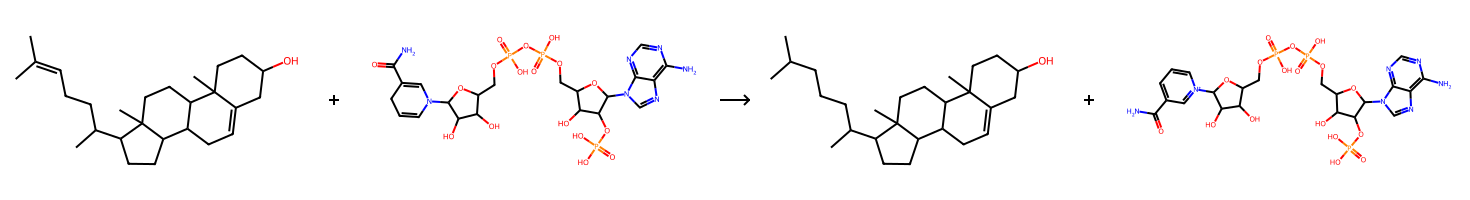

In [17]:

display(SVG(filename=img_dir / f"{krid}.svg"))

In [143]:
img_dir / f"{krid}.svg"

PosixPath('/home/stef/quest_data/bottle/data/processed/test/svgs/b5d9bdaa57b5aa799ea99d09b51ccbdb72fdb4fe.svg')